In [11]:
from mmdet.apis import init_detector, inference_detector
from mmdet.utils import register_all_modules
from mmdet.registry import VISUALIZERS
import mmcv
import math
import numpy as np
# happy drawing 
import matplotlib.pyplot as plt

In [12]:
refinement_steps = 50
config_file = './projects/configs/eqdet_r101_2x_coco.py'
checkpoint_file = './deqdet_r101_2x_epoch_24.pth'
demo_image_file = 'README/cat_cow1.jpg'

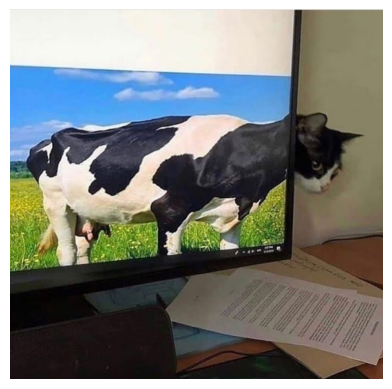

In [13]:
# read image
img = mmcv.imread(demo_image_file, channel_order='rgb')
plt.imshow(img)
plt.axis('off')
plt.show()

In [14]:
#Register all modules in mmdet into the registries
register_all_modules()
# build the model from a config file and a checkpoint file
model = init_detector(config_file, checkpoint_file, device='cuda:0')  # or device='cpu'
# init the visualizer(execute this block only once)
visualizer = VISUALIZERS.build(model.cfg.visualizer)
# the dataset_meta is loaded from the checkpoint and
# then pass to the model in init_detector
visualizer.dataset_meta = model.dataset_meta
# show the results

Loads checkpoint by local backend from path: ./deqdet_r101_2x_epoch_24.pth


/home/wangshuai/anaconda3/envs/openmmlab/lib/python3.8/site-packages/mmengine/utils/manager.py:113: UserWarning: <class 'mmdet.visualization.local_visualizer.DetLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(


In [15]:
refinement_images = []
for i in range(refinement_steps):
    model.roi_head.refinement_steps = i
    result = inference_detector(model, np.flip(img, 2))
    visualizer.add_datasample(
        'result',
        img,
        data_sample=result,
        pred_score_thr=0.25,
        draw_gt=False,
        wait_time=0,
    )
    refinement_images.append(visualizer.get_image())

/home/wangshuai/anaconda3/envs/openmmlab/lib/python3.8/site-packages/mmengine/visualization/visualizer.py:760: UserWarning: Warning: The bbox is out of bounds, the drawn bbox may not be in the image
  warnings.warn(
/home/wangshuai/anaconda3/envs/openmmlab/lib/python3.8/site-packages/mmengine/visualization/visualizer.py:831: UserWarning: Warning: The polygon is out of bounds, the drawn polygon may not be in the image
  warnings.warn(


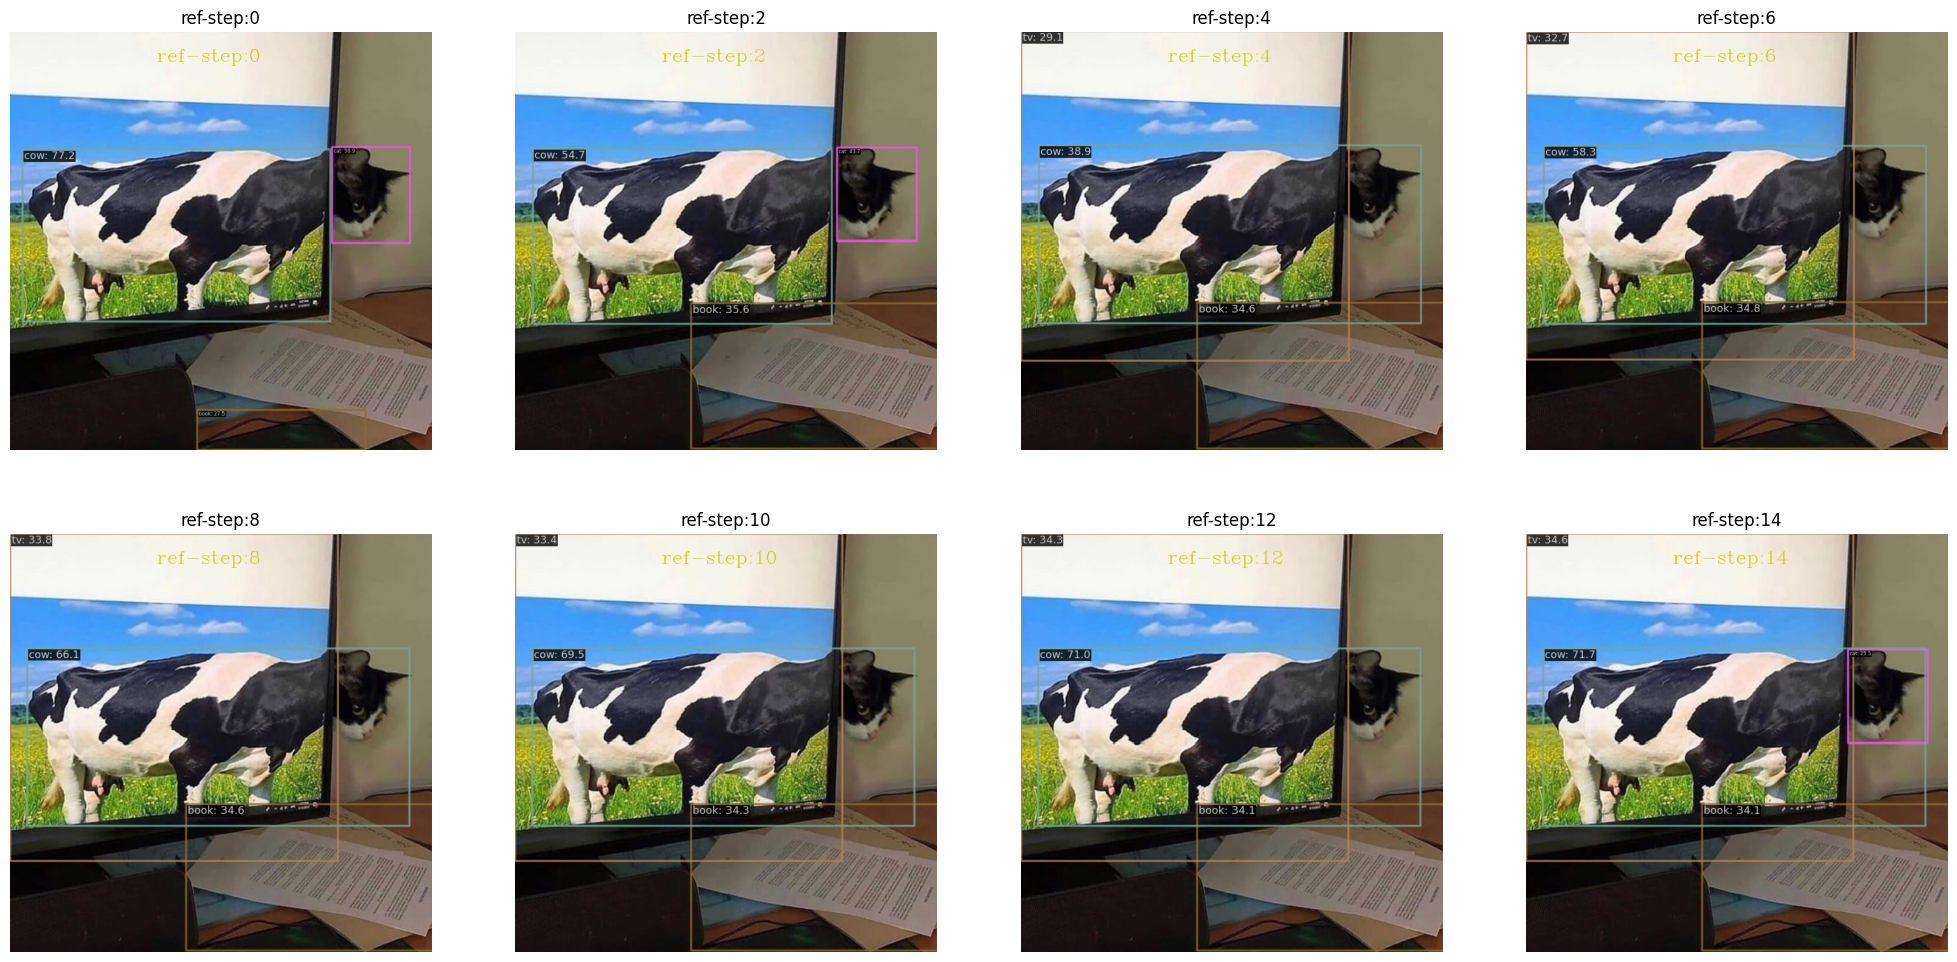

In [8]:
columns = 4
fig = plt.figure(figsize=(25, 25))
for i, out_image in enumerate(refinement_images):
        if i % 2 != 0 or i > 15: continue 
        ax = fig.add_subplot(math.ceil(15/columns),columns, i//2+1)
        ax.set_title("ref-step:"+str(i))
        plt.imshow(out_image)
        plt.axis('off')
plt.show()

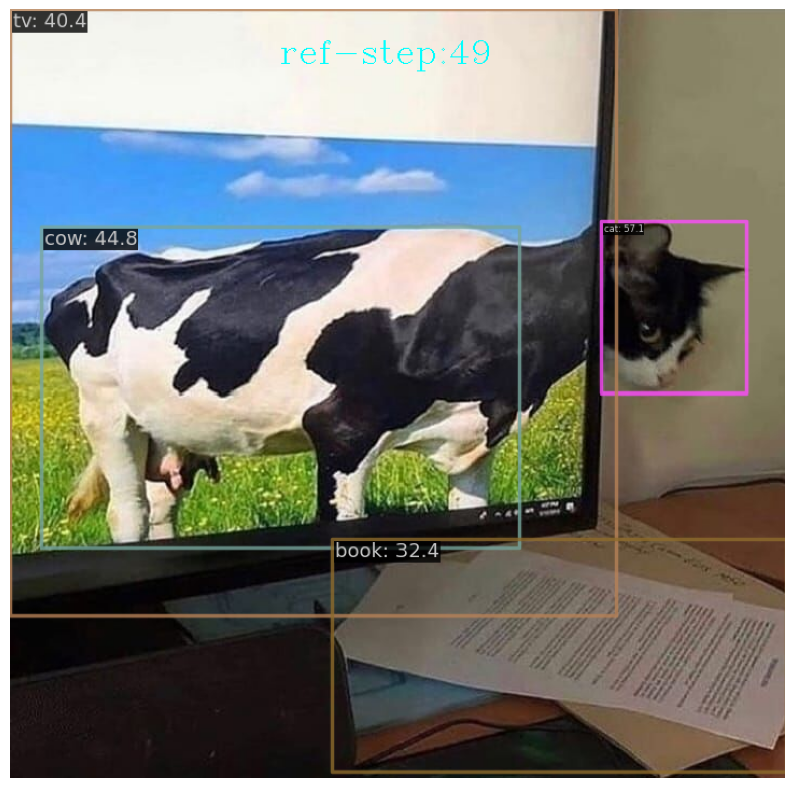

In [16]:
import cv2
import matplotlib.animation as animation
frames = []
fig = plt.figure(figsize=(10, 10))
for i, out_image in enumerate(refinement_images):
        out_image =cv2.putText(img=out_image, text="ref-step:"+str(i), org=(250,50),fontFace=3, fontScale=1, color=(0,255,255), thickness=1)
        frames.append([plt.imshow(out_image,animated=True)])
        plt.axis('off')
video = animation.ArtistAnimation(fig, frames, interval=1, blit=True, repeat_delay=1)
video.save('README/refinement_r101.gif')
plt.show()